# DEA Smoke Test

## Summary

A great deal of work has been done by AGDC partners to outline the key requirements and technical approach for the next version of the AGDC (Version 2). For example, the previous Technical Working Group held a workshop that resulted in a draft Preliminary Design Report that has subsequently been translated to the AGDC wiki ( http://datacube.org.au ). Similarly, prototype functionality has been built to test and verify key concepts for a range of components including the netCDF-4 based Storage Units that are managed under NCIfs NERDIP data management, publishing and general access to data protocols; a Generalised Data Framework (GDF) to access the multidimensional Storage Units; and the AGDC Analytic Engine adding support for interactive Exploratory Data Analysis (EDA).

The following requirements for Version 2 have been mainly based off this thinking and documentation. It is important to note that these requirements are for the current development effort running through till June 30, 2016. They are designed to guide and define the next step in the development of the AGDC, not as the final destination.


Approved Requirements for AGDC Version 2

These requirements were formally approved by the AGDC Programme Board at its meeting on 10
December, 2015.

# Patterns of Use:
AGDC Version 2 will support the following patterns of use.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube
from datacube.model import Range
from datetime import datetime
from datacube.utils import geometry
from datacube.storage import masking
from datacube.storage.masking import mask_invalid_data
import pandas
import xarray
import numpy

In [2]:
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
#from datacube.model import datacube.utils.geometry.CRS
import time
from dateutil import tz

In [3]:
notebook_start_dt = datetime.now()

In [4]:
dc = datacube.Datacube(app='requirements-met')

In [5]:
datacube.__version__

'1.6rc1+28.ga69dfff'

In [6]:
datacube.__path__

['/g/data1a/u46/users/sm9911/python-env/datacube-core/datacube']

In [7]:
!module list

Currently Loaded Modulefiles:
  1) pbs                3) dea-env/20180405
  2) git/2.9.5          4) udunits/2.1.24


In [8]:
!datacube system check

Version:       1.6rc1+28.ga69dfff
Config files:  /g/data/u46/users/sm9911/python-env/datacube.conf,datacube.conf
Host:          130.56.244.105:6432
Database:      datacube
User:          None
Environment:   None
Index Driver:  default

Valid connection:	YES


# Remote Datacube


In [9]:
from datacube import Datacube
#remotedc = Datacube(config='/home/547/jps547/.aws_datacube.conf')

 # Test for native projection query on non standard rainfall product

In [10]:
query = {
    'product': 'bom_rainfall_grids',
    'crs': 'EPSG:3577',
    'time': ('1987-10-01', '1990-10-01'),
    'x': (349388.9787330463, 358497.9246628304),
    'y': (-2379960.5883129314, -2375926.544118764),
    'output_crs': 'EPSG:3577', 
    'resolution': (-25, 25),
    'resampling': 'cubic',
}

rainfall_projected = dc.load(**query)

In [11]:
print(rainfall_projected)

<xarray.Dataset>
Dimensions:   (time: 1096, x: 365, y: 162)
Coordinates:
  * time      (time) datetime64[ns] 1987-10-01 1987-10-02 1987-10-03 ...
  * y         (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x         (x) float64 3.494e+05 3.494e+05 3.494e+05 3.495e+05 3.495e+05 ...
Data variables:
    rainfall  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577


In [12]:
rainfall_projected = None

# Search for dataset by location example

In [13]:
# Was replaced by stacked file
# ds_uri = 'file:///g/data/rs0/datacube/002/LS5_TM_NBART/-7_-30/LS5_TM_NBART_3577_-7_-30_20030711011529000000_v1488078639.nc'

ds_uri = 'file:///g/data/rs0/datacube/002/LS5_TM_NBAR/13_-35/LS5_TM_NBAR_3577_13_-35_2009_v1496827052.nc'
datasets_in_stack = list(dc.index.datasets.get_datasets_for_location(uri=ds_uri))

# If restacked, there will be a newer file (with higher vXXX version suffix)
# So this one shouldn't change:
assert len(datasets_in_stack) == 74
assert set(d.type.name for d in datasets_in_stack) == {'ls5_nbar_albers'}
print(repr(datasets_in_stack[0]))

datasets_in_stack = None

Dataset <id=00adc495-be06-4235-bee3-9de40d38a8db type=ls5_nbar_albers location=/g/data/rs0/datacube/002/LS5_TM_NBAR/13_-35/LS5_TM_NBAR_3577_13_-35_2009_v1496827052.nc>


In [14]:
def chop_to_globe(geom):
    to_crs = geometry.CRS("EPSG:4326")
    left_of_dt = geometry.line(
        [
            (180 - 1.0e-8, -90), 
            (180 - 1.0e-8, 90)
        ], 
        crs=to_crs
    ).to_crs(geom.crs)
    
    right_of_dt = geometry.line(
        [
            (-180 + 1.0e-8, 90), 
            (-180 + 1.0e-8, -90)
        ], 
        crs=to_crs
    ).to_crs(geom.crs)

    chopper = geometry.polygon(
        left_of_dt.points + right_of_dt.points + [left_of_dt.points[0]], 
        crs=geom.crs
    )
    return geom.intersection(chopper)

def datasets_union_clip180(dss):
    thing = geometry.unary_union(ds.extent for ds in dss)
    return chop_to_globe(thing).to_crs(geometry.CRS('EPSG:4326'))

In [15]:
def datasets_union(dss):
    thing = geometry.unary_union(ds.extent for ds in dss)
    print(thing.crs)
    return thing.to_crs(geometry.CRS('EPSG:4326'))

In [16]:
import random
def plot_folium(shapes):

    mapa = folium.Map(location=[-30,150], zoom_start=4)
    colors=['#00ff00', '#ff0000', '#00ffff', '#ffffff', '#000000', '#ff00ff']
    for shape in shapes:
        style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00', 
                                    'color' : random.choice(colors)}
        poly = folium.features.GeoJson(mapping(shape), style_function=style_function)
        mapa.add_child(poly)
    display(mapa)

In [17]:
def plot_rgb(image, fake_saturation):
    image = mask_invalid_data(image)
    rgb = image.to_array(dim='color')
    rgb = rgb.transpose(*(rgb.dims[1:] + rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow

    rgb.plot.imshow(
        x=image.crs.dimensions[1], 
        y=image.crs.dimensions[0],
        col='time', 
        col_wrap=5, 
        add_colorbar=False
    )

# GQA based search

In [18]:
# Get NBAR where source level1 matches a certain quality

source_filter = dict(product='ls8_level1_scene', gqa_cep90=(-0.25, 0.25))

query = datacube.api.query.Query(
    product='ls8_nbar_albers', 
    time=('2015-01-01', '2015-02-01'), 
    source_filter=source_filter
)
data = dc.index.datasets.search_eager(**query.search_terms)

In [19]:
len(data)

2749

In [20]:
data[0]

Dataset <id=00556b09-6e28-421d-8b38-33700433cd3a type=ls8_nbar_albers location=/g/data/rs0/datacube/002/LS8_OLI_NBAR/-9_-30/LS8_OLI_NBAR_3577_-9_-30_2015_v1496400956.nc>

# Search with sources

In [21]:
(
     dc.index.datasets.get('11228944-42f6-4b9f-a434-73e0c7f9bde2', include_sources=True)
).metadata_doc['lineage']['source_datasets']['0']['lineage']['source_datasets']['level1']['gqa']

{'colors': {'red': 4.0,
  'blue': 18.0,
  'teal': 55.0,
  'green': 253.0,
  'yellow': 7.0},
 'ref_date': '2015-02-03',
 'residual': {'abs': {'x': 0.19, 'y': 0.39, 'xy': 0.43},
  'mean': {'x': 0.06, 'y': -0.13, 'xy': 0.14},
  'cep90': 0.53,
  'stddev': {'x': 0.4, 'y': 0.79, 'xy': 0.88},
  'iterative_mean': {'x': 0.05, 'y': -0.09, 'xy': 0.1},
  'iterative_stddev': {'x': 0.13, 'y': 0.28, 'xy': 0.3},
  'abs_iterative_mean': {'x': 0.11, 'y': 0.22, 'xy': 0.24}},
 'ref_source': 'GQA_v3',
 'error_message': 'no errors',
 'final_gcp_count': 286,
 'ref_source_path': '/g/data/v10/eoancillarydata/GCP/GQA_v3/wrs2/099/079/LC80990792015034LGN00_B6.TIF'}

# Refine search using sources

In [22]:
from datacube.model import Range
results=[]
for product in ['ls5_level1_scene']:
    results.append(dc.index.datasets.search_eager(
        product=product,
        sat_path = Range(91,92),
        sat_row = Range(88,90),
    ))
print(len(results))
print(str(results[0][0].local_path))

1
/g/data/v10/reprocess/ls5/level1/2004/12/LS5_TM_OTH_P51_GALPGS01-002_091_089_20041228/ga-metadata.yaml


In [23]:
from datacube.model import Range
time_range = Range(datetime(2013, 10, 1), datetime(2014, 1, 1))
results = dc.index.datasets.search_eager(
    product='ls8_nbar_albers',
    time=time_range,
    source_filter=dict(
        product='ls8_level1_scene',
        sat_path = Range(87,116),
        sat_row = Range(67,91),
    )
)
print(len(results))
print(results[0])

19926
Dataset <id=00037981-a131-42b4-9d6c-818b170876d2 type=ls8_nbar_albers location=/g/data/rs0/datacube/002/LS8_OLI_NBAR/-16_-20/LS8_OLI_NBAR_3577_-16_-20_2013_v1496416918.nc>


In [24]:
results[0].metadata_doc

{'id': '00037981-a131-42b4-9d6c-818b170876d2',
 'image': {'bands': {'nir': {'path': '', 'layer': 'nir'},
   'red': {'path': '', 'layer': 'red'},
   'blue': {'path': '', 'layer': 'blue'},
   'green': {'path': '', 'layer': 'green'},
   'swir1': {'path': '', 'layer': 'swir1'},
   'swir2': {'path': '', 'layer': 'swir2'},
   'coastal_aerosol': {'path': '', 'layer': 'coastal_aerosol'}}},
 'extent': {'coord': {'ll': {'lat': -17.92211829467786,
    'lon': 117.55633296123455},
   'lr': {'lat': -17.949776440040374, 'lon': 117.81303688442733},
   'ul': {'lat': -17.735014564282437, 'lon': 117.57847647232195},
   'ur': {'lat': -17.762644355615926, 'lon': 117.83479338134532}},
  'to_dt': '2013-11-14T02:09:45.500000',
  'from_dt': '2013-11-14T02:09:45.500000',
  'center_dt': '2013-11-14T02:09:45.500000'},
 'format': {'name': 'NetCDF'},
 'lineage': {'machine': {'uname': 'Linux r2779 2.6.32-642.1.1.el6.x86_64 #1 SMP Tue May 31 21:57:07 UTC 2016 x86_64',
   'hostname': 'r2779',
   'software_versions': {

In [25]:
results = None

# Grid Cell count of timeslices

In [26]:
product = 'ls8_nbar_albers'

gw = datacube.api.GridWorkflow(dc.index, product=product)
cells = gw.list_cells(product=product, time=('2016-01-01', '2017-01-01'))

for idx, data in cells.items():
    print(idx, data.shape[0])
    
cells = None

(0, -17) 90
(1, -13) 90
(-1, -19) 90
(-1, -21) 90
(0, -21) 92
(-1, -22) 90
(1, -18) 92
(1, -15) 46
(2, -17) 92
(1, -20) 92
(0, -20) 69
(0, -16) 68
(2, -13) 92
(0, -14) 67
(-1, -20) 90
(2, -14) 92
(0, -13) 90
(0, -23) 92
(0, -19) 31
(0, -18) 89
(-1, -23) 89
(2, -16) 69
(1, -16) 92
(-2, -22) 67
(0, -22) 69
(-2, -23) 90
(1, -19) 92
(1, -17) 92
(2, -15) 92
(-1, -17) 67
(0, -15) 90
(-1, -18) 90
(1, -21) 73
(1, -14) 90
(12, -26) 90
(13, -25) 68
(10, -28) 90
(12, -23) 67
(11, -29) 67
(11, -23) 90
(9, -28) 100
(9, -29) 90
(12, -24) 67
(13, -24) 90
(10, -33) 90
(11, -26) 67
(12, -25) 90
(10, -30) 91
(8, -33) 90
(9, -32) 90
(10, -32) 90
(12, -22) 90
(10, -25) 89
(11, -25) 90
(11, -24) 90
(9, -30) 90
(13, -23) 68
(11, -27) 67
(13, -22) 90
(12, -27) 90
(9, -33) 91
(10, -26) 90
(10, -31) 90
(11, -30) 90
(8, -32) 68
(8, -31) 92
(10, -29) 70
(11, -28) 90
(12, -28) 68
(11, -31) 68
(9, -31) 90
(10, -27) 90
(11, -22) 90
(18, -39) 88
(16, -42) 92
(13, -46) 138
(17, -44) 46
(16, -41) 92
(16, -44) 46
(18, 

(-11, -18) 92
(-10, -19) 92
(-10, -20) 64
(-4, -35) 67
(-4, -36) 90
(11, -47) 92
(12, -44) 92
(8, -49) 46
(9, -47) 46
(9, -48) 23
(-4, -10) 45
(10, -48) 69
(11, -46) 92
(9, -49) 69
(-5, -11) 23
(10, -47) 92
(10, -49) 92
(-5, -10) 23
(8, -48) 23
(-4, -11) 45
(-6, -36) 90
(-5, -36) 113
(-5, -34) 90
(-5, -32) 90
(-5, -33) 90
(-5, -35) 90
(-4, -37) 68
(-5, -31) 90
(-6, -35) 68
(-6, -23) 90
(-6, -24) 67
(-7, -26) 90
(-7, -25) 90
(-7, -27) 68
(-7, -23) 90
(-7, -24) 67
(-6, -25) 74
(3, -40) 69
(4, -41) 115
(3, -41) 92
(-10, -22) 91
(-9, -21) 69
(-9, -22) 92
(-9, -20) 92
(-17, -33) 69
(-16, -32) 93
(-18, -24) 92
(-18, -26) 92
(-17, -28) 92
(-18, -27) 92
(-16, -26) 92
(-17, -26) 85
(-18, -25) 69
(-16, -28) 92
(-16, -29) 92
(-17, -31) 69
(-16, -24) 92
(-17, -29) 92
(-17, -32) 92
(-17, -24) 92
(-16, -31) 92
(-16, -27) 92
(-17, -27) 46
(-16, -30) 92
(-17, -25) 69
(-17, -30) 92
(-16, -25) 69
(-18, -28) 69
(23, -22) 44
(24, -24) 44
(25, -20) 44
(25, -23) 44
(25, -24) 44
(24, -20) 44
(24, -22) 44
(25

# Query products by time range - return count

### Count for single query

In [27]:
# Count of single query
product = 'ls7_nbar_scene'
start_time = time.time()
count = dc.index.datasets.count(
    product=product, 
    time=Range(datetime(2000, 1, 1), datetime(2001, 1, 1))
)
print("Single product {} count of {} in {} seconds ---".format(product, count, time.time() - start_time))

Single product ls7_nbar_scene count of 6936 in 0.10048317909240723 seconds ---


#### Count products through time

In [28]:
start_time = time.time()

results = dc.index.datasets.count_by_product_through_time(
    '1 year',
    platform='LANDSAT_7',
    time=Range(
        datetime(2000, 1, 1),
        datetime(2003, 1, 1), #, tzinfo=tz.tzutc()),
    )
)

start_product_time = time.time()
for product, series in results:
    print('{}: {} seconds'.format(product.name, time.time() - start_product_time))
    for timerange, count in series:
        print('\t{}: {}'.format(timerange[0], count))
    start_product_time = time.time()

print("--- %s seconds ---" % (time.time() - start_time))


high_tide_comp_20p: 0.025249719619750977 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
high_tide_comp_count: 0.00662541389465332 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
item_v2: 0.0063817501068115234 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
item_v2_conf: 0.0062656402587890625 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
low_tide_comp_20p: 0.006432056427001953 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
low_tide_comp_count: 0.006122589111328125 seconds
	2000-01-01 00:00:00+11:00: 0
	2001-01-01 00:00:00+11:00: 0
	2002-01-01 00:00:00+11:00: 0
ls7_fc_albers: 11.485943794250488 seconds
	2000-01-01 00:00:00+11:00: 62989
	2001-01-01 00:00:00+11:00: 66821
	2002-01-01 00:00:00+11:00: 67158
ls7_fc_albers_archived: 9.5517718791

# Data load examples

In [29]:
dc.list_measurements()

aliases  \
product                        measurement                                            
bom_rainfall_grids             rainfall                                         NaN   
dsm1sv10                       elevation                                        NaN   
gamma_ray                      rad_air_dose_rate_unfiltered                     NaN   
                               rad_k_equiv_conc_unfiltered                      NaN   
                               rad_u_equiv_conc_unfiltered                      NaN   
                               rad_th_equiv_conc_unfiltered                     NaN   
                               rad_air_dose_rate_filtered                       NaN   
                               rad_k_equiv_conc_filtered                        NaN   
                               rad_u_equiv_conc_filtered                        NaN   
                               rad_th_equiv_conc_filtered                       NaN   
                               rad_ratio_tk                                     NaN   
                               rad_ratio_u2t                                    NaN   
                               rad_ratio_uk                                     NaN   
                               rad_ratio_ut                                     NaN   
high_tide_comp_20p             blue                                             NaN   
                               green                                            NaN   
                               red                                              NaN   
                               nir                                              NaN   
                               swir1                                            NaN   
                               swir2                                            NaN   
high_tide_comp_count           count_observations                               NaN   
item_v2                        relative                                         NaN   
item_v2_conf                   stddev                                           NaN   
low_tide_comp_20p              blue                                             NaN   
                               green                                            NaN   
                               red                                              NaN   
                               nir                                              NaN   
                               swir1                                            NaN   
                               swir2                                            NaN   
low_tide_comp_count            count_observations                               NaN   
...                                                                             ...   
modis_mcd43a3_tile             Albedo_WSA_shortwave                             NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band1         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band2         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band3         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band4         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band5         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band6         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band7         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_nir           NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_shortwave     NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_vis           NaN   
modis_mcd43a4_tile             BRDF_Albedo_Band_Mandatory_Quality_Band1         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band2         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band3   

# Load SRTM

In [30]:
query = {
    'lat': (-20.61, -20.66),
    'lon': (147.0, 147.05)
}

srtm_dem1sv1_0 = dc.load(product='srtm_dem1sv1_0', **query)

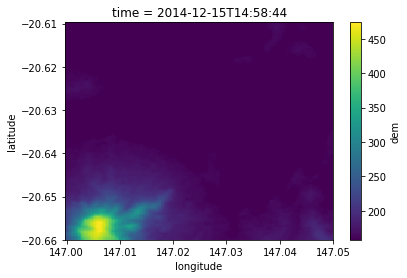

In [31]:
srtm_dem1sv1_0.dem.plot()

In [32]:
srtm_dem1sv1_0 = None

# Load Radiometrics

<xarray.DataArray 'rad_u_equiv_conc_filtered' ()>
array(3.245694)
<xarray.Dataset>
Dimensions:                     (latitude: 50, longitude: 50, time: 1)
Coordinates:
  * time                        (time) datetime64[ns] 2015-10-15
  * latitude                    (latitude) float64 -20.61 -20.61 -20.61 ...
  * longitude                   (longitude) float64 147.0 147.0 147.0 147.0 ...
Data variables:
    rad_k_equiv_conc_filtered   (time, latitude, longitude) float32 0.024998955 ...
    rad_th_equiv_conc_filtered  (time, latitude, longitude) float32 0.030957075 ...
    rad_u_equiv_conc_filtered   (time, latitude, longitude) float32 -0.720119 ...
Attributes:
    crs:      GEOGCS["GEOCENTRIC DATUM of AUSTRALIA",DATUM["GDA94",SPHEROID["...


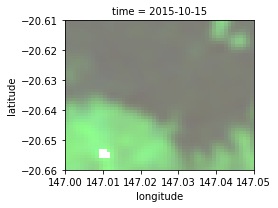

In [33]:
query = {
    'lat': (-20.61, -20.66),
    'lon': (147.0, 147.05),
    'measurements':['rad_k_equiv_conc_filtered','rad_th_equiv_conc_filtered','rad_u_equiv_conc_filtered']
}

# Gamma ray no longer available at indexed location?
try:
    radiometrics = dc.load(product='gamma_ray', **query)
    
    # Previously: array(3.2456936836242676)
    print(radiometrics.rad_u_equiv_conc_filtered.max())
    
    
    print(radiometrics)
    plot_rgb(radiometrics, 20)
    
except Exception as e:
    print(repr(e))
    
    
    


In [34]:
radiometrics = None

# Load NBAR

In [35]:
nbar = dc.load(
    product='ls5_nbart_albers', 
    y=(-18.7896944682,-18.7896944684), 
    x=(146.073501475,146.073501476)
)

In [36]:
#print(nbar)

In [37]:
#nbar = None

## MODIS Landsat time series

In [38]:
modis = dc.load(
    product='modis_mcd43a4_tile', 
    longitude=132.1,
    latitude=-27.5, 
    time=('2000-1-1', '2000-5-1'), 
    resolution=(-500,500), 
    # measurements=('Nadir_Reflectance_Band1','Nadir_Reflectance_Band4','Nadir_Reflectance_Band3'),
)

In [39]:
# Josh archived all of this product.
#modis.Nadir_Reflectance_Band1.min()
assert len(modis) == 0

print(modis)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
modis = None

# Load rainfall

In [41]:
rain = dc.load(product='bom_rainfall_grids', longitude=132.1, latitude=-27.5, time=('2000-1-1', '2001-1-1'))

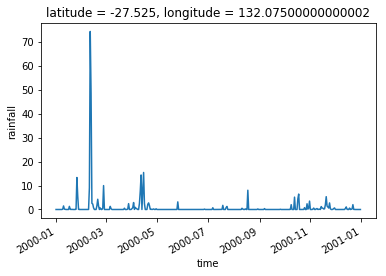

In [42]:
rain.rainfall.sel(longitude=132.1, latitude=-27.500001, method='nearest').plot()

In [43]:
rain = None

## 1. Routine national scale product generation. Specifically, Version 2 will include national collections of:
    
 Water Observations from Space.

In [44]:
dc.index.datasets.search_eager(product='srtm_dem1sv1_0')

[Dataset <id=007f754d-6b3b-4a34-beaf-557c4eff2daa type=srtm_dem1sv1_0 location=/g/data/v10/AGDCv2/indexed_datasets/srtm/Elevation_1secSRTM_DEMs_v1.0_DEMSH_Mosaic_dem1sv1_0.yaml>]

In [45]:
rain_ds = dc.index.datasets.search_eager(product='bom_rainfall_grids', time=Range(datetime(2001, 1, 1), datetime(2002, 1, 1)))

datasets_union_clip180(rain_ds).to_crs(geometry.CRS('EPSG:3577'))

Geometry(POLYGON ((-1653001.91713634 -4992823.38195036,-1669479.35576637 -4888562.72164336,-1686059.9405326 -4783649.40624165,-1702735.69770219 -4678133.88937894,-1719498.87797482 -4572065.20459653,-1736341.95151559 -4465490.99677279,-1753257.60277401 -4358457.55490568,-1770238.72513968 -4251009.84592903,-1787278.41547946 -4143191.54927854,-1804369.9685957 -4035045.091957,-1821506.87164047 -3926611.68387806,-1838682.79851627 -3817931.35329609,-1855891.60428951 -3709042.98215426,-1873127.31963985 -3599984.34120652,-1890384.14536488 -3490792.12478911,-1907656.44695683 -3381501.98513614,-1924938.74926544 -3272148.5661504,-1942225.7312586 -3162765.53655517,-1959512.22089045 -3053385.62236614,-1976793.19008477 -2944040.6386342,-1994063.74983965 -2834761.52042014,-2011319.14545838 -2725578.35297147,-2028554.75190983 -2616520.40107926,-2045766.06932083 -2507616.13760022,-2062948.71860187 -2398893.27113481,-2080098.4372068 -2290378.77285768,-2097211.07502643 -2182098.902501,-2114282.59041524 -

In [46]:
rain_ds = None

In [47]:
plot_folium([
    datasets_union_clip180(
        dc.index.datasets.search_eager(
            product='bom_rainfall_grids', 
            time=Range(datetime(2001, 1, 1), datetime(2002, 1, 1))
        )
    )
])

In [48]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='srtm_dem1sv1_0',  
            time=Range(datetime(2001, 1, 1), datetime(2020, 1, 1))
        )
    )
])

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]]


In [49]:
# Josh archived all of this
modis_mcd43a4 = dc.load(
    product='modis_mcd43a4_tile',
    x=(145,145.1),
    y=(-38.0,-38.1),
    resolution=(-500,500),
    time=('2000-01-01', '2001-01-01'), 
    measurements=(
        'Nadir_Reflectance_Band1',
        'Nadir_Reflectance_Band4',
        'Nadir_Reflectance_Band3'
    )
)

In [50]:
print(modis_mcd43a4)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


In [51]:
modis_mcd43a4 = None

# Multiband file or subdataset support example

In [52]:
%%script false
# Modis disabled. Josh archived all of this

modis_mcd43a1 = dc.load(
    product='modis_mcd43a1_tile',
    x=(145,145.1),
    y=(-38.0,-38.1),
    resolution=(-500,500),
    time=('2001-01-01', '2001-01-01'), 
    measurements=(
        'BRDF_Albedo_Parameters_Band1',
        'BRDF_Albedo_Parameters_Band2',
        'BRDF_Albedo_Parameters_Band3'
    )
)

# Query, load and plot NBART example 

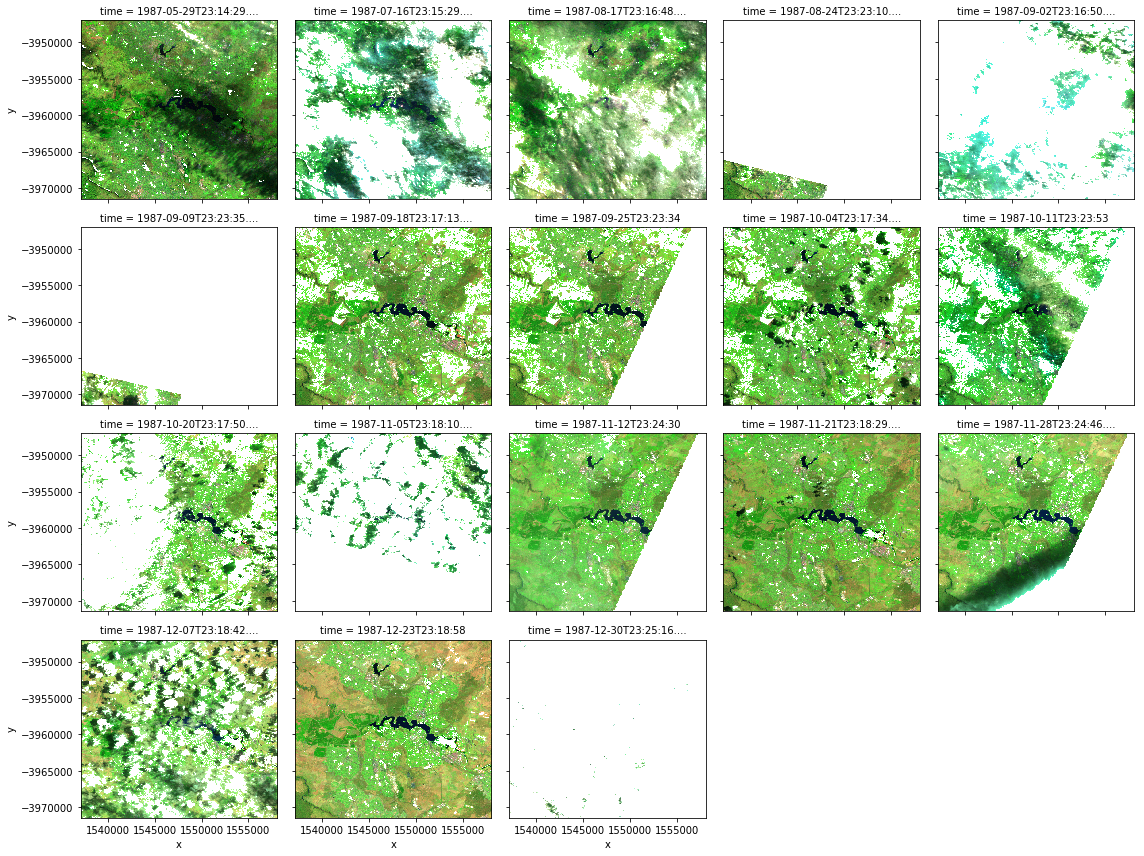

In [53]:
query = {
    'time': ('1987-01-01', '1988-01-01'),
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

nbart = dc.load(
    product='ls5_nbart_albers',
    measurements=['swir2', 'nir', 'red'], 
    group_by='solar_day' , 
    **query
)

plot_rgb(nbart, 3500)

In [54]:
nbart = None

# Query, load and plot WoFS example 
# Construction of the Burdekin Dam completed in 1987

In [55]:
%%script false
# Disabled: WOfS has been removed.

query = {
    'time': ('1986-01-01', '1988-01-01'),
    'lat': (-20.61, -20.67),
    'lon': (147.0, 147.15),
}

wofs = dc.load(product='wofs_albers', group_by='solar_day', **query)
wofs

In [56]:
%%script false
wofs.water.flags_definition
pandas.DataFrame.from_dict(masking.get_flags_def(wofs), orient='index')

In [57]:
%%script false

water = masking.make_mask(wofs, result='clear_wet')
water.water.plot(col='time', col_wrap=5, robust=True, cmap='gray')

In [58]:
%%script false
# Number of clear water pixels - no group by solar day to exclude scene overlap

water_sum = water.water.sum('time').where(water.water.sum('time')!= 0)
water_sum.plot(cmap='rainbow', robust=True)

In [59]:
wofs = None
water = None
water_sum = None

 Intertidal Characterisation.

 ## Landsat Fractional Cover.

In [60]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='ls5_fc_albers',
            time=Range(datetime(1987, 1, 1), datetime(1988, 1, 1))
        )
    )
])

EPSG:3577


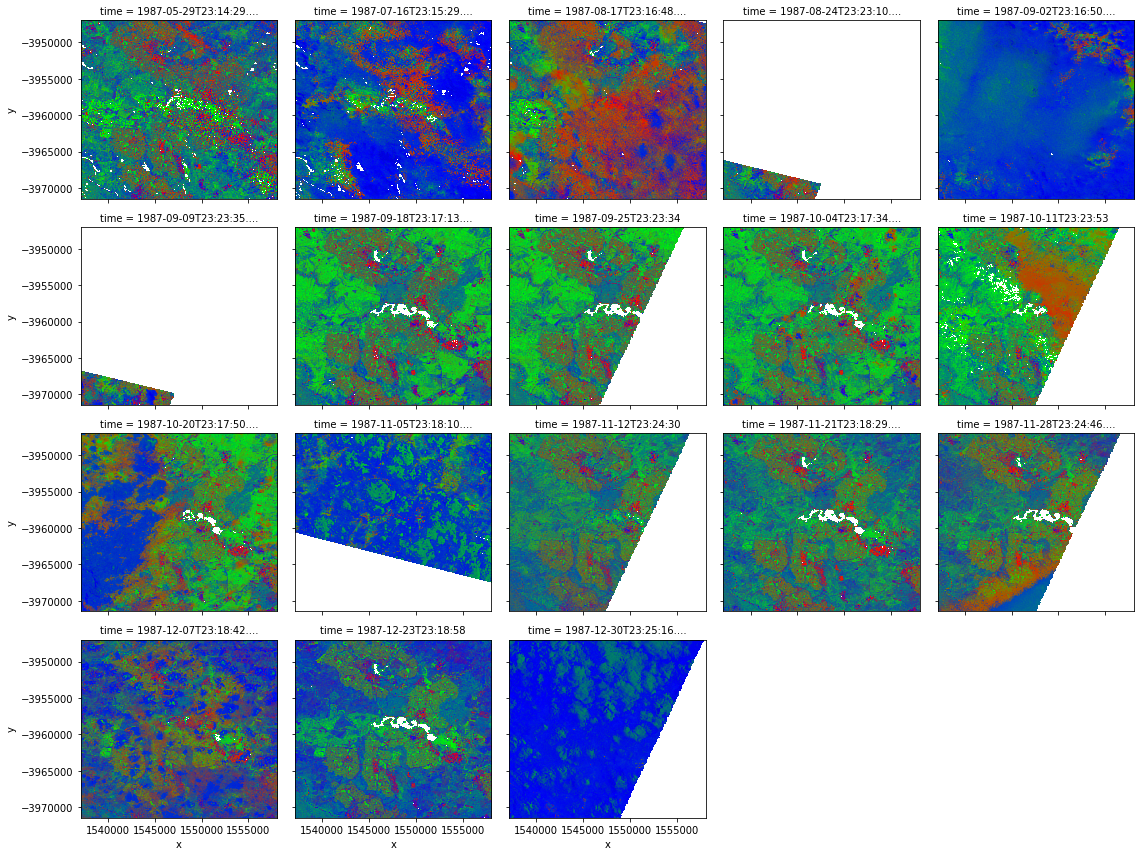

In [61]:
# Query, load and plot Fractional Cover example 

query = {
    'time': ('1987-01-01', '1988-01-01'),
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

fractional_cover = dc.load(
    product='ls5_fc_albers',
    measurements=['BS', 'PV', 'NPV'], 
    group_by='solar_day' , 
    **query
)

plot_rgb(fractional_cover, 100)

In [62]:
fractional_cover = None

## Pixel Quality

In [63]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='ls5_pq_albers',
            time=Range(datetime(1987, 1, 1), datetime(1988, 1, 1))
        )
    )
])

EPSG:3577


In [64]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='ls7_nbar_albers',
           time=Range(datetime(2004,2, 1), datetime(2004, 2, 16))
        )
    )
])

EPSG:3577


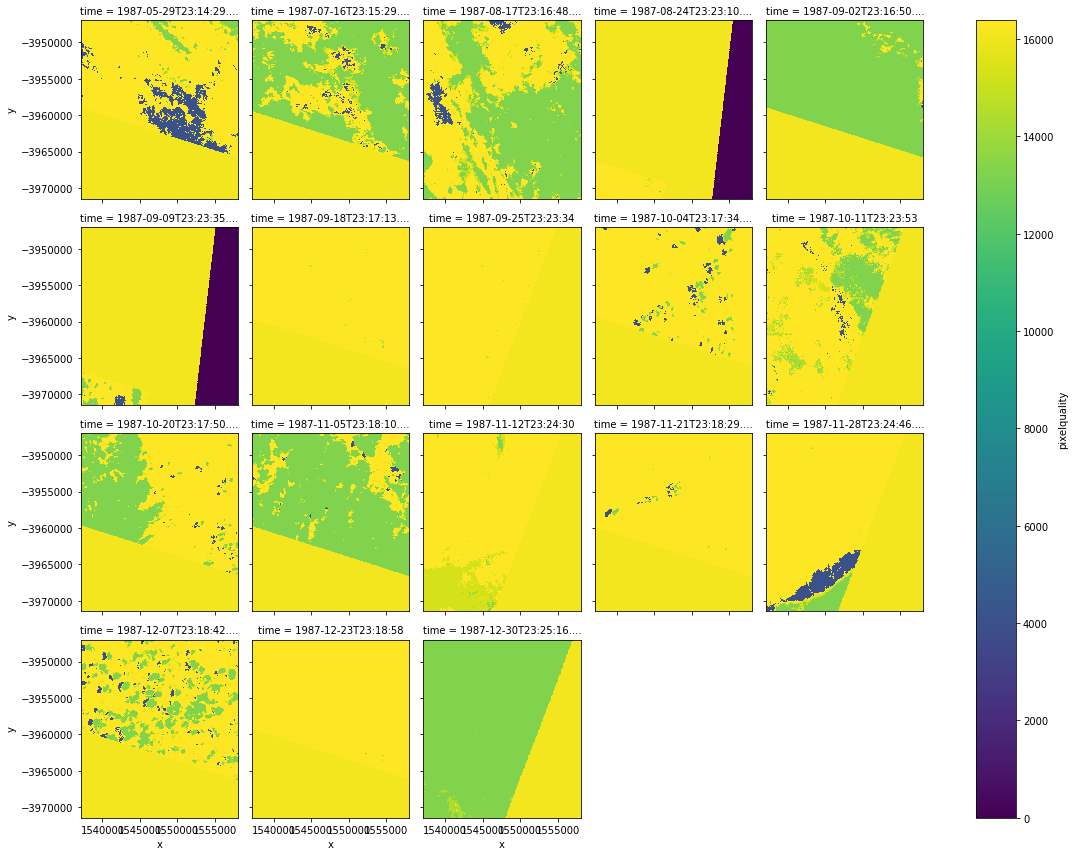

In [65]:
pq = dc.load(product='ls5_pq_albers', group_by='solar_day', **query)
pq.pixelquality.plot(col='time', col_wrap=5, robust=True)

In [66]:
# Number of clear pixels based on ga_good_pixels default - no group by solar day to exclude scene overlap
clear_pixels = masking.make_mask(pq, ga_good_pixel=True)
clear_pixels.pixelquality.sum('time').plot(cmap='rainbow')

In [67]:
clear_pixels = None

 NDVI.

In [68]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='ls5_ndvi_albers',
            time=Range(datetime(1987,1, 1), datetime(1988, 1, 1))
        )
    )
])

EPSG:3577


In [69]:
#ndvi = dc.load(product='ls5_ndvi_albers', group_by='solar_day', **query )
#ndvi = mask_invalid_data(ndvi)
good_pixels = masking.make_mask(pq, ga_good_pixel=True)
#ndvi = ndvi.where(good_pixels.pixelquality)
#ndvi.ndvi.plot(col='time', col_wrap=5, robust=True, cmap='Greens')
print(good_pixels)

<xarray.Dataset>
Dimensions:       (time: 18, x: 839, y: 979)
Coordinates:
  * time          (time) datetime64[ns] 1987-05-29T23:14:29.500000 ...
  * x             (x) float64 1.537e+06 1.537e+06 1.537e+06 1.537e+06 ...
  * y             (y) float64 -3.947e+06 -3.947e+06 -3.947e+06 -3.947e+06 ...
Data variables:
    pixelquality  (time, y, x) bool True True True True True True True True ...
Attributes:
    crs:      EPSG:3577



    
In some cases, these collections may be virtual, i.e. they are not pre-computed but rather
computed as they are needed.


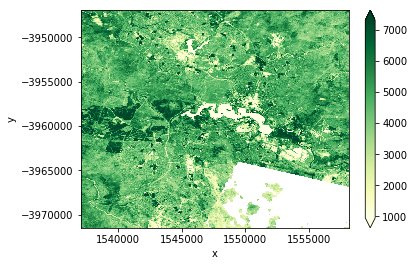

In [70]:
nbar = dc.load(product='ls5_nbar_albers', group_by='solar_day', **query )
nbar = nbar.where(good_pixels.pixelquality)
ndvi_on_the_fly = (nbar.nir-nbar.red)/(nbar.nir+nbar.red)*10000
ndvi_on_the_fly.median(dim='time').plot(robust=True, cmap='YlGn')

## CLI Dataset info, search

In [71]:
! datacube dataset info 92d414d0-3d82-4702-9e24-4af6e49d95b5

id: 92d414d0-3d82-4702-9e24-4af6e49d95b5
product: ls8_nbart_albers
status: active
indexed: 2016-07-28 22:13:28.471331+10:00
locations:
- file:///g/data/rs0/datacube/002/LS8_OLI_NBART/-3_-34/LS8_OLI_NBART_3577_-3_-34_2015_v1493806523.nc
fields:
    format: NetCDF
    instrument: OLI_TIRS
    lat: {begin: -31.008598143445397, end: -30.309997675003654}
    lon: {begin: 129.70822913784428, end: 129.89758790971382}
    platform: LANDSAT_8
    product_type: nbart
    time: {begin: '2015-10-29T01:09:32', end: '2015-10-29T01:09:32'}


In [72]:
! datacube dataset info -f csv 92d414d0-3d82-4702-9e24-4af6e49d95b5

In [73]:
! datacube dataset search \
            product=ls8_level1_scene \
           "time in range (2015-3-2, 2015-3-19)" \
            sat_path=112 \
            sat_row=75

id: 6bbbea4c-510a-40ad-a71b-4d37fb621ef8
product: ls8_level1_scene
status: active
locations:
- file:///g/data/v10/reprocess/ls8/level1/2015/03/LS8_OLITIRS_OTH_P51_GALPGS01-032_112_075_20150318/ga-metadata.yaml
fields:
    ancillary_quality: null
    format: GeoTIFF
    gqa: null
    gqa_abs_iterative_mean_xy: 0.07
    gqa_abs_xy: 0.13
    gqa_cep90: 0.13
    gqa_error_message: no errors
    gqa_final_gcp_count: 237
    gqa_iterative_mean_xy: 0.02
    gqa_iterative_stddev_xy: 0.09
    gqa_mean_xy: 0.02
    gqa_ref_source: GQA_v3
    gqa_stddev_xy: 0.18
    gsi: LGN
    instrument: OLI_TIRS
    lat: {begin: -22.747785, end: -20.595875}
    lon: {begin: 118.041952, end: 120.313276}
    orbit: null
    platform: LANDSAT_8
    product_type: level1
    sat_path: {begin: 112.0, end: 112.0}
    sat_row: {begin: 75.0, end: 75.0}
    time: {begin: '2015-03-18T02:01:59', end: '2015-03-18T02:02:31'}


## 2. A user should be able to interact with these collections through a web browser including:#

Clicking on a pixel and displaying a time series (i.e., pixel drill).

In [74]:
# See Steven Ackerley / Andrew Hicks
# NCML through THREDDS
#!/g/data/v10/public/agdcv2-pixeldrill/pixeldrill -p ls5_nbart_albers

#Webpage to define it
!firefox http://dapds00.nci.org.au/thredds/ncss/grid/uc0/rs0_dev/all_the_ncmls/LS5_TM_FC/ncml/LS5_TM_FC_13_-43.ncml/pointDataset.html

In [75]:
#CSV URL for a drill
!firefox http://dapds00.nci.org.au/thredds/ncss/uc0/rs0_dev/all_the_ncmls/LS5_TM_FC/ncml/LS5_TM_FC_13_-43.ncml?var=BS&var=NPV&var=PV&latitude=-38.13&longitude=147.17&time_start=1986-08-21T23%3A18%3A40Z&time_end=2011-11-14T23%3A45%3A07Z&accept=csv


### Spatio-temporal (statistical) summaries that would allow users to easily answer questions such as:
    
    How frequently was water observed over catchment y during time period x; and



    What was the surface reflectance for area x at time y?

Link to [stats within a polygon](zonal-stats-pilbara.ipynb)

## 3. Earth Observation (EO) scientists and allied domain specialists will be able to undertake exploratory data analysis. In general this would mean a user will be able to easily retrieve, investigate, visualise, develop algorithms, test, iterate, visualise results and interpret them in the context of other spatio-temporal datasets.

 A key demonstration of this capability will be the availability of functions and data
structures to enable Landsat/MODIS blending.

### Input data
The AGDC will use the following data collections:
 Landsat: TM, ETM+ and OLI/TIRS.
 MODIS: Collection 6 MOD09 (granule) and MOD43 (sinusoidal tiles) that will provide variables
necessary for the Landsat-MODIS blending algorithm.

In [76]:
dc.list_products()

name  \
id                                   
36              bom_rainfall_grids   
32                        dsm1sv10   
53                       gamma_ray   
63              high_tide_comp_20p   
64            high_tide_comp_count   
67                         item_v2   
68                    item_v2_conf   
65               low_tide_comp_20p   
66             low_tide_comp_count   
69                   ls5_fc_albers   
42          ls5_fc_albers_archived   
2                 ls5_level1_scene   
6                  ls5_nbar_albers   
3                   ls5_nbar_scene   
26                ls5_nbart_albers   
4                  ls5_nbart_scene   
41                 ls5_ndvi_albers   
23                   ls5_pq_albers   
75             ls5_pq_legacy_scene   
5                     ls5_pq_scene   
1     ls5_satellite_telemetry_data   
70                   ls7_fc_albers   
44          ls7_fc_albers_archived   
72           ls7_fc_albers_staging   
9                 ls7_level1_scene   
21                 ls7_nbar_albers   
10                  ls7_nbar_scene   
29                ls7_nbart_albers   
11                 ls7_nbart_scene   
45                 ls7_ndvi_albers   
22                   ls7_pq_albers   
76             ls7_pq_legacy_scene   
12                    ls7_pq_scene   
8     ls7_satellite_telemetry_data   
71                   ls8_fc_albers   
40            ls8_level1_oli_scene   
14                ls8_level1_scene   
19                 ls8_nbar_albers   
60             ls8_nbar_oli_albers   
57              ls8_nbar_oli_scene   
15                  ls8_nbar_scene   
28                ls8_nbart_albers   
61            ls8_nbart_oli_albers   
58             ls8_nbart_oli_scene   
16                 ls8_nbart_scene   
55                 ls8_ndvi_albers   
20                   ls8_pq_albers   
74         ls8_pq_legacy_oli_scene   
73             ls8_pq_legacy_scene   
59                ls8_pq_oli_scene   
17                    ls8_pq_scene   
13    ls8_satellite_telemetry_data   
49              modis_mcd43a1_tile   
50              modis_mcd43a2_tile   
51              modis_mcd43a3_tile   
52              modis_mcd43a4_tile   
56                  srtm_dem1sv1_0   
77                     wofs_albers   
62  wofs_modified_albers2_archived   

                                          description  sat_row  gqa  lat  \
id                                                                         
36  Interpolated Rain Gauge Precipitation 1-Day Au...      NaN  NaN  NaN   
32                               DSM 1sec Version 1.0      NaN  NaN  NaN   
53  The 2015 radiometric or gamma-ray grid of Aust...      NaN  NaN  NaN   
63  High Tide 20 percentage composites for entire ...      NaN  NaN  NaN   
64                High Tide 20 percentage pixel count      NaN  NaN  NaN   
67                           Intertidal Extents Model      NaN  NaN  NaN   
68                    Average ndwi Standard Deviation      NaN  NaN  NaN   
65  Low Tide 20 percentage composites for entire c...      NaN  NaN  NaN   
66                 Low Tide 20 percentage pixel count      NaN  NaN  NaN   
69  Landsat 5 Fractional Cover 25 metre, 100km til...      NaN  NaN  NaN   
42  Landsat 5 Fractional Cover 25 metre, 100km til...      NaN  NaN  NaN   
2       Landsat 5 Level 1 At-sensor Radiance 25 metre      NaN  NaN  NaN   
6   Landsat 5 Surface Reflectance NBAR 25 metre, 1...      NaN  NaN  NaN   
3                             Landsat 5 NBAR 25 metre      NaN  NaN  NaN   
26  Landsat 5 Surface Reflectance NBART 25 metre, ...      NaN  NaN  NaN   
4                            Landsat 5 NBART 25 metre      NaN  NaN  NaN   
41  Landsat 5 Normalised Difference Vegetation Ind...      NaN  NaN  NaN   
23  Landsat 5 Pixel Quality 25 metre, 100km tile, ...      NaN  NaN  NaN   
75                       Landsat 5 PQ Legacy 25 metre      NaN  NaN  NaN   
5                               Landsat 5 PQ 25 metre      NaN  NaN  NaN   
1                  Landsat 5 Satellite 

It will also include the SRTM 3 second DSM and 1 and 3 second DEMs.

In [77]:
dc.list_measurements()

aliases  \
product                        measurement                                            
bom_rainfall_grids             rainfall                                         NaN   
dsm1sv10                       elevation                                        NaN   
gamma_ray                      rad_air_dose_rate_unfiltered                     NaN   
                               rad_k_equiv_conc_unfiltered                      NaN   
                               rad_u_equiv_conc_unfiltered                      NaN   
                               rad_th_equiv_conc_unfiltered                     NaN   
                               rad_air_dose_rate_filtered                       NaN   
                               rad_k_equiv_conc_filtered                        NaN   
                               rad_u_equiv_conc_filtered                        NaN   
                               rad_th_equiv_conc_filtered                       NaN   
                               rad_ratio_tk                                     NaN   
                               rad_ratio_u2t                                    NaN   
                               rad_ratio_uk                                     NaN   
                               rad_ratio_ut                                     NaN   
high_tide_comp_20p             blue                                             NaN   
                               green                                            NaN   
                               red                                              NaN   
                               nir                                              NaN   
                               swir1                                            NaN   
                               swir2                                            NaN   
high_tide_comp_count           count_observations                               NaN   
item_v2                        relative                                         NaN   
item_v2_conf                   stddev                                           NaN   
low_tide_comp_20p              blue                                             NaN   
                               green                                            NaN   
                               red                                              NaN   
                               nir                                              NaN   
                               swir1                                            NaN   
                               swir2                                            NaN   
low_tide_comp_count            count_observations                               NaN   
...                                                                             ...   
modis_mcd43a3_tile             Albedo_WSA_shortwave                             NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band1         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band2         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band3         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band4         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band5         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band6         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band7         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_nir           NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_shortwave     NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_vis           NaN   
modis_mcd43a4_tile             BRDF_Albedo_Band_Mandatory_Quality_Band1         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band2         NaN   
                               BRDF_Albedo_Band_Mandatory_Quality_Band3   

At a minimum, the Australian implementation of the AGDC will cover all of continental Australia plus a
one tile buffer and the Great Barrier Reef. However, the Boards preference would be for the Version
2 to also cover all Commonwealth Marine Reserves.

In [78]:
plot_folium([
    datasets_union(
        dc.index.datasets.search_eager(
            product='ls8_nbar_albers',
            time=Range(datetime(2014,1, 1), datetime(2015, 1, 1))
        )
    )
])

EPSG:3577


All data collections that are included in the Australian implementation of the AGDC will:
 Have a CC BY Attribution 3.0 or CC BY Attribution 4.0 license. 

In [79]:
!ncdump -h '/g/data/rs0/datacube/002/LS5_TM_NBAR/14_-40/LS5_TM_NBAR_3577_14_-40_19860821231816000000.nc' | grep license

		:license = "CC BY Attribution 4.0 International License" ;


The use of a collection with a
different licence will require approval of the AGDC Programme Board; and
 Be in netCDF 4 format and will comply with relevant CF conventions;.

In [80]:
import compliance_checker

In [81]:
compliance_checker.__version__

'3.1.1'

In [82]:
from __future__ import print_function
import argparse
import sys

import cf_units
from compliance_checker.runner import ComplianceChecker, CheckSuite
from compliance_checker import __version__

ds_loc = '/g/data/rs0/datacube/002/LS5_TM_NBAR/14_-40/LS5_TM_NBAR_3577_14_-40_19860821231816000000.nc'

cs = CheckSuite()
cs.load_all_available_checkers()

was_success, errors = ComplianceChecker.run_checker(
    ds_loc=ds_loc, 
    checker_names=['cf'], # 'acdd'?
    verbose=0, 
    criteria='normal', 
    output_filename='-',
    # Skipping:
    # - check_dimension_order: 
    #      Our files don't contain all the lats/lons as an auxiliary 
    #      cordinate var as it's unnecessary for any software we've 
    #      tried.
    #      It may be added at some point in the future, and this check 
    #      should be re-enabled.
    skip_checks=['check_dimension_order']
)
# missing source attribute: skippable according to Damien
# assert was_success, "Compliance failed."



--------------------------------------------------------------------------------
                    The dataset scored 263 out of 264 points                    
                              during the cf check                               
--------------------------------------------------------------------------------
                               Scoring Breakdown:                               


                                 High Priority                                  
--------------------------------------------------------------------------------
    Name                            :Priority: Score
§2.2 Valid netCDF data types            :3:    11/11
§2.4 Unique dimensions                  :3:    11/11
§3.1 Variable blue contains valid CF un :3:     3/3
§3.1 Variable green contains valid CF u :3:     3/3
§3.1 Variable nir contains valid CF uni :3:     3/3
§3.1 Variable red contains valid CF uni :3:     3/3
§3.1 Variable swir1 contains valid CF u :3:     3/3
§3.1 Varia

In [83]:
help(ComplianceChecker.run_checker)

Help on method run_checker in module compliance_checker.runner:

run_checker(ds_loc, checker_names, verbose, criteria, skip_checks=None, output_filename='-', output_format='text') method of builtins.type instance
    Static check runner.
    
    @param  ds_loc          Dataset location (url or file)
    @param  checker_names    List of string names to run, should match keys of checkers dict (empty list means run all)
    @param  verbose         Verbosity of the output (0, 1, 2)
    @param  criteria        Determines failure (lenient, normal, strict)
    @param  output_filename Path to the file for output
    @param  skip_checks     Names of checks to skip
    @param  output_format   Format of the output
    
    @returns                If the tests failed (based on the criteria)



## Output Products
By June 30, 2016 the Australian implementation of the AGDC will ensure that the products being
produced are supported by and hosted on the RDS.

In [84]:
!ls /g/data/rs0/datacube/002

LS5_TM_NBAR   LS5_TM_PQ     LS7_ETM_NBART  LS8_OLI_NBAR   LS8_OLI_PQ
LS5_TM_NBART  LS7_ETM_NBAR  LS7_ETM_PQ	   LS8_OLI_NBART


In [85]:
!ls /g/data/fk4/datacube/002

FC  HLTC  ITEM	stats  WOfS


## Technical Requirements
In line with the use-case patterns outlined above, Version 2 will support:
 Data-fusion and analysis across heterogeneous gridded data collections from different
domains.

In [86]:
albers_grid = dc.load(
    product='ls5_nbart_albers', 
    group_by='solar_day',
    measurements=['swir2', 'nir', 'blue'], 
    **query
)

In [87]:
sinusoidal_grid = dc.load(
    product='ls5_nbar_albers',  
    group_by='solar_day', 
    measurements=['swir2', 'nir', 'blue'],
    output_crs='PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",\
                DATUM["Not specified (based on custom spheroid)",\
                SPHEROID["Custom spheroid",6371007.181,0]],\
                PRIMEM["Greenwich",0],\
                UNIT["degree",0.0174532925199433]],\
                PROJECTION["Sinusoidal"],\
                PARAMETER["longitude_of_center",0],\
                PARAMETER["false_easting",0],\
                PARAMETER["false_northing",0],\
                UNIT["Meter",1]]',
    resolution=(-250,250), 
    **query
)

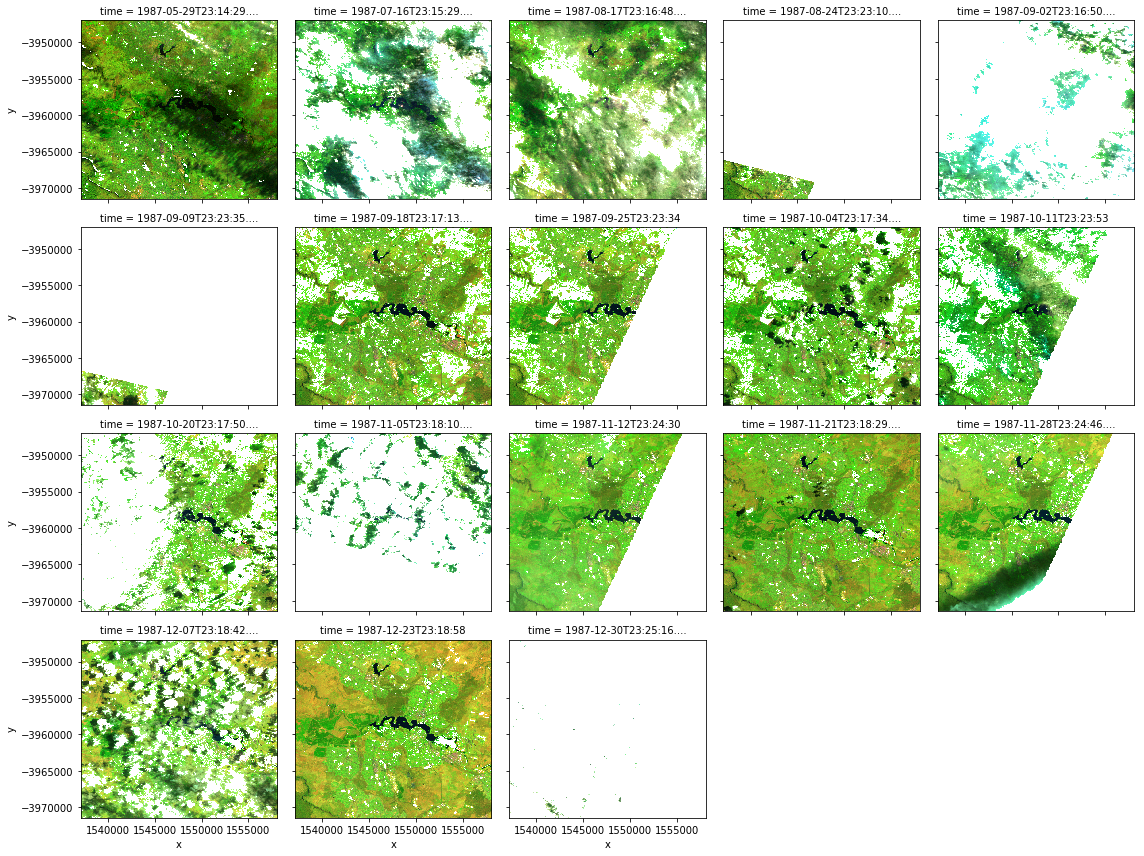

In [88]:
plot_rgb(albers_grid, 3500)
albers_grid = None

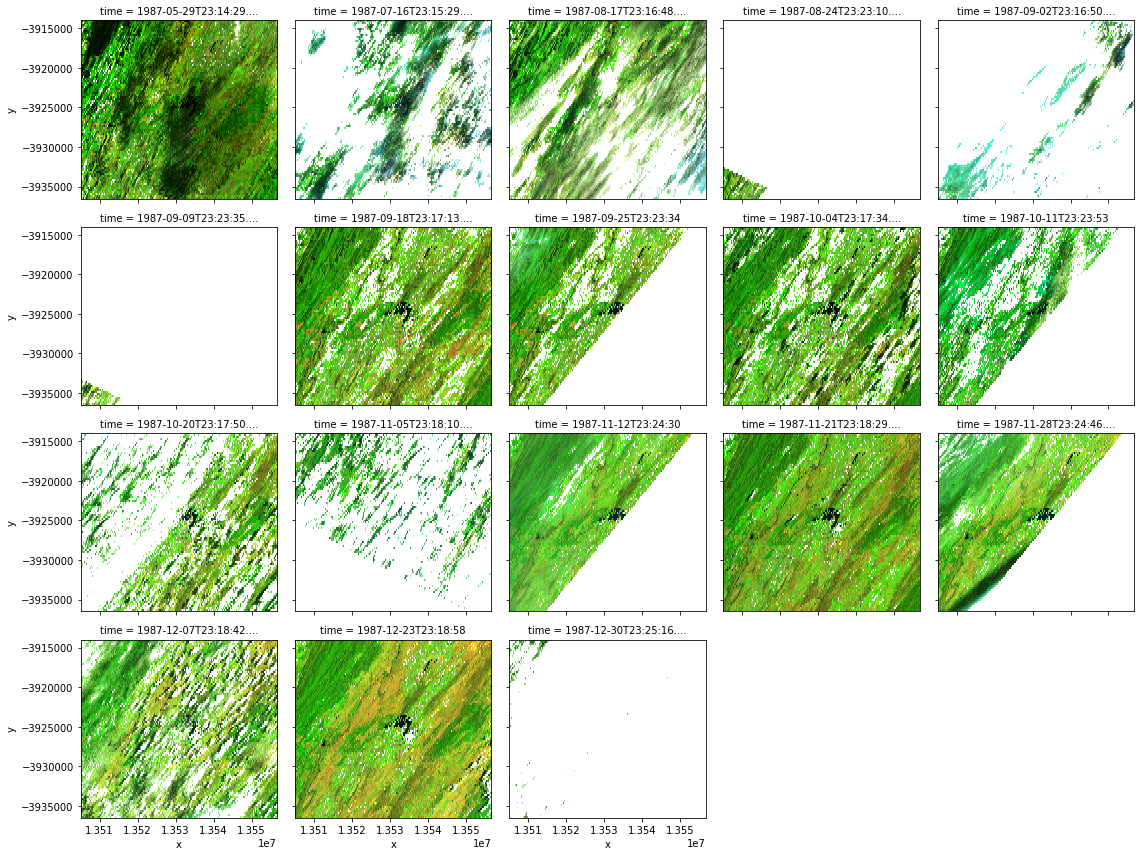

In [89]:
plot_rgb(sinusoidal_grid, 3500)
sinusoidal_grid = None

Tuneable configuration, at ingest, of multidimensional files (eg. chunking, compression type,
dimension depth).

In [90]:
!datacube product add --help

Usage: datacube product add [OPTIONS] [FILES]...

  Add or update products in the generic index.

Options:
  --allow-exclusive-lock / --forbid-exclusive-lock
                                  Allow index to be locked from other users
                                  while updating (default: false)
  -h, --help                      Show this message and exit.


## A data retrieval mechanism that provides the ability to:


Obtain seamless subsets of data across storage unit boundaries;


In [91]:
seamless_query = {
    'time': ('2011-6-1', '2011-6-30'),
    'lat': (-20, -30),
    'lon': (132.0, 132.01),
}

In [92]:
seamless_subset = dc.load(
    product='ls5_nbar_albers', 
    measurements=['swir2', 'nir', 'blue'], 
    group_by='solar_day', 
    **seamless_query
)

In [93]:
seamless_subset.y.max() - seamless_subset.y.min() #distance in metres

<xarray.DataArray 'y' ()>
array(1119225.)

In [94]:
seamless_subset.x.max() - seamless_subset.x.min() #distance in metres

<xarray.DataArray 'x' ()>
array(1025.)

In [95]:
seamless_subset.extent.points

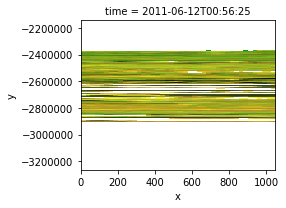

In [96]:
plot_rgb(seamless_subset, 3000)

In [97]:
# With the Grid Workflow class demonstrate seamless spatial query across tile boundaries
from datacube.api import GridWorkflow  

In [98]:
gw = GridWorkflow(dc.index, product='ls5_nbar_albers')

In [99]:
# The query straddles multiple tiles - indexes shown below
gw.list_cells(
    product = 'ls5_nbar_albers', 
    **seamless_query
).keys()

dict_keys([(0, -26), (0, -29), (0, -24), (0, -28), (0, -30), (0, -27), (0, -25)])


Filter data based on observation attribute (for example, pixel quality);

bits  \
blue_saturated                                                   0   
cloud_acca                                                      10   
cloud_fmask                                                     11   
cloud_shadow_acca                                               12   
cloud_shadow_fmask                                              13   
contiguous                                                       8   
ga_good_pixel       [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]   
green_saturated                                                  1   
land_sea                                                         9   
nir_saturated                                                    3   
red_saturated                                                    2   
swir1_saturated                                                  4   
swir2_saturated                                                  7   
tir_saturated                                                    5   

                                                           values  \
blue_saturated                            {'0': True, '1': False}   
cloud_acca                        {'0': 'cloud', '1': 'no_cloud'}   
cloud_fmask                       {'0': 'cloud', '1': 'no_cloud'}   
cloud_shadow_acca   {'0': 'cloud_shadow', '1': 'no_cloud_shadow'}   
cloud_shadow_fmask  {'0': 'cloud_shadow', '1': 'no_cloud_shadow'}   
contiguous                                {'0': False, '1': True}   
ga_good_pixel                                     {'16383': True}   
green_saturated                           {'0': True, '1': False}   
land_sea                                {'0': 'sea', '1': 'land'}   
nir_saturated                             {'0': True, '1': False}   
red_saturated                             {'0': True, '1': False}   
swir1_saturated                           {'0': True, '1': False}   
swir2_saturated                           {'0': True, '1': False}   
tir_saturated                             {'0': True, '1': False}   

                                                         description  
blue_saturated                                Blue band is saturated  
cloud_acca                                              Cloud (ACCA)  
cloud_fmask                                            Cloud (Fmask)  
cloud_shadow_acca                                Cloud Shadow (ACCA)  
cloud_shadow_fmask                              Cloud Shadow (Fmask)  
contiguous          All bands for this pixel contain non-null values  
ga_good_pixel                                     Best Quality Pixel  
green_saturated                              Green band is saturated  
land_sea                                                 Land or Sea  
nir_saturated                                  NIR band is saturated  
red_saturated                                  Red band is saturated  
swir1_saturated                              SWIR1 band is saturated  
swir2_saturated                              SWIR2 band is saturated  
tir_saturated                     Thermal Infrared band is saturated

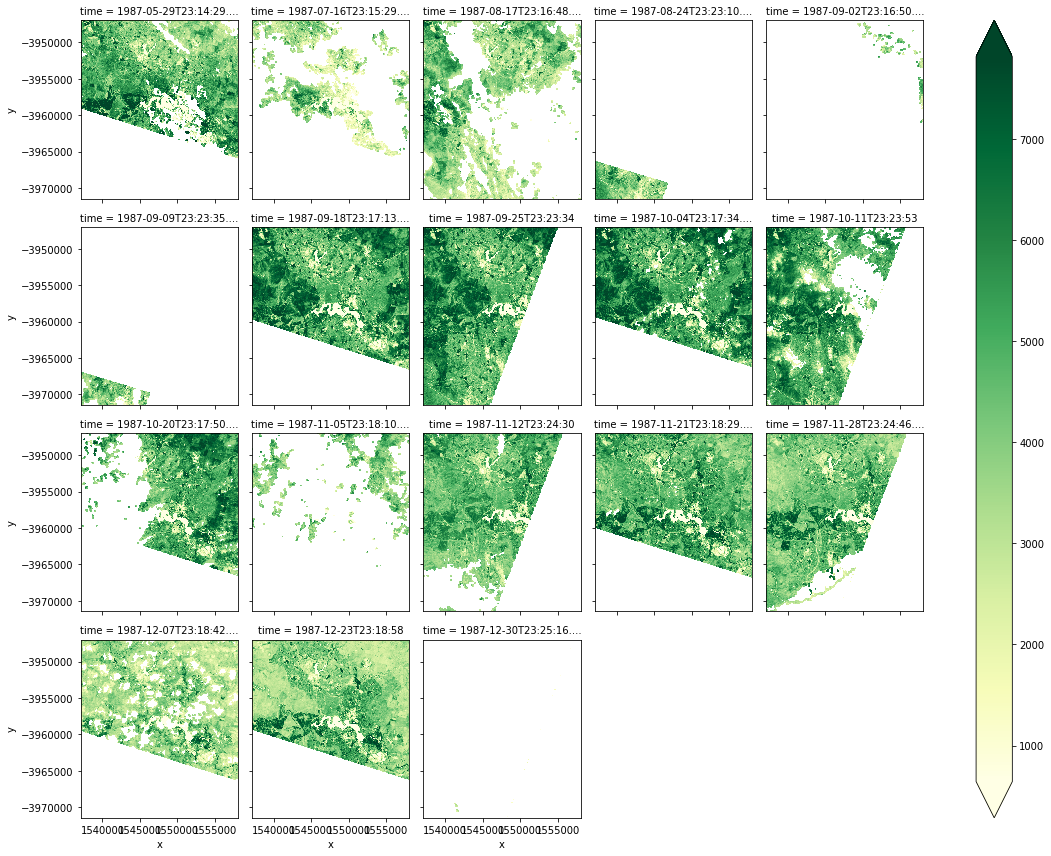

In [100]:

# Load some NDVI
nbar = dc.load(product='ls5_nbar_albers', group_by='solar_day', **query) 
ndvi = (nbar.nir - nbar.red) / (nbar.nir + nbar.red) * 10000
nbar = None

# Mask the valid data
ndvi = mask_invalid_data(ndvi)
# Create a mask for the data with artefacts
good_pixels = masking.make_mask(pq, ga_good_pixel=True) 
# Apply artefact mask
ndvi = ndvi.where(good_pixels.pixelquality) 

# Plot the result
ndvi.plot(col='time', col_wrap=5, robust=True, cmap='YlGn') 
ndvi = None

pandas.DataFrame.from_dict(
    masking.get_flags_def(pq), 
    orient='index'
)


Define the spatio-temporal range of interest independent of data storage unit; and define the specific sensor or combination of sensor data to be analysed.



In [101]:
multi_sensor_query = {
    'time': ('2013-06-01', '2014-01-01'),
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

products = ['ls7_nbar_albers', 'ls8_nbar_albers']

# Find similarly named measurements
measurements = set(dc.index.products.get_by_name(products[0]).measurements.keys())
for prod in products[1:]:
    measurements.intersection(dc.index.products.get_by_name(products[0]).measurements.keys())

datasets = []
for prod in products:
    ds = dc.load(product=prod, measurements=measurements, **multi_sensor_query)
    ds['product'] = ('time', numpy.repeat(prod, ds.time.size))
    datasets.append(ds)

combined = xarray.concat(datasets, dim='time')
combined = combined.sortby('time')

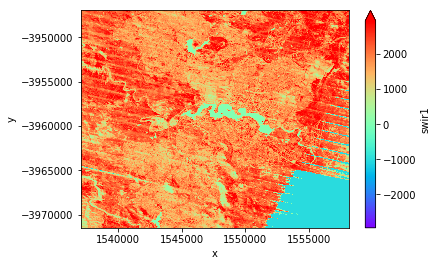

In [102]:
combined.swir1.median(dim='time').plot(col_wrap=5, robust=True, cmap='rainbow')

The API will provide a simplified conceptual model for data query and analysis based
on an n-dimensional array abstraction;

In [103]:
combined.data_vars

Data variables:
    green    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    blue     (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    nir      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    swir2    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    red      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    product  (time) <U15 'ls7_nbar_albers' 'ls7_nbar_albers' ...

In [104]:
combined = None

During EDA, lazy evaluation of calculations so only those results that are in use are
computed; and

Support for calculations on arrays that are larger than core memory.

In [105]:
# Dask Example
lazydata = dc.load(
    product='ls7_nbart_albers',
    longitude=(132.0, 137.0), 
    latitude=(-20, -25), 
    time=('2011-6-1', '2011-6-30'),
    dask_chunks={'x': 200, 'y': 200, 'time': 5} 
)

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/_collections_abc.py:743: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


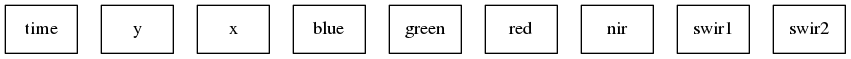

In [106]:
from dask.dot import dot_graph

dot_graph(lazydata)

In [107]:
print(lazydata)

<xarray.Dataset>
Dimensions:  (time: 35, x: 20829, y: 22731)
Coordinates:
  * time     (time) datetime64[ns] 2011-06-04T01:00:14.500000 ...
  * y        (y) float64 -2.144e+06 -2.144e+06 -2.144e+06 -2.144e+06 ...
  * x        (x) float64 12.5 37.5 62.5 87.5 112.5 137.5 162.5 187.5 212.5 ...
Data variables:
    blue     (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
    green    (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
    red      (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
    nir      (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
    swir1    (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
    swir2    (time, y, x) int16 dask.array<shape=(35, 22731, 20829), chunksize=(5, 200, 200)>
Attributes:
    crs:      EPSG:3577


In [108]:
# If larger than memory will be chunked and run
print(lazydata.mean(dim='time'))


<xarray.Dataset>
Dimensions:  (x: 20829, y: 22731)
Coordinates:
  * y        (y) float64 -2.144e+06 -2.144e+06 -2.144e+06 -2.144e+06 ...
  * x        (x) float64 12.5 37.5 62.5 87.5 112.5 137.5 162.5 187.5 212.5 ...
Data variables:
    blue     (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>
    green    (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>
    red      (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>
    nir      (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>
    swir1    (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>
    swir2    (y, x) float64 dask.array<shape=(22731, 20829), chunksize=(200, 200)>


Web based delivery of products through WMS, WCS, CS/W, OpenDAP services.

In [109]:
!firefox http://dapds00.nci.org.au/thredds/catalogs/rs0/catalog.html 

## Other Requirements
### The Project Plan will be supported by:
 A transition plan and timetable for moving AGDC production from Version 1 to Version 2 of
the AGDC (including controlled updates to data collections that are already accessible via
RDS);

In [110]:
!firefox http://dapds00.nci.org.au/thredds/catalogs/rs0/catalog.html 

A software release and management plan;

Approved by Robert Woodcock, Matt Paget and Simon Oliver 19/01/2016

1.	Develop branch - aim is to have this not broken - integration tests should enforce expected functionality on this branch 
a.	integration tests are trying to enforce this
b.	Develop is the main collaboration branch
i.	To discourage keeping feature branches separate for too long - small incremental improvements are better
2.	Master to be replaced with git tagged releases (these should not deviate greatly from develop)
a.	The process to get to release could be :
i.	Decide when develop is feature complete
ii.	Branch it to a release candidate
iii.	Test the release candidate (manual - apply patches as needed to branch)
iv.	Tag release
3.	Continuous integration tests are run on every checkin to check core functionality- currently includes all of the ingestion code - in the process of extending to include storage access.
a.	To merge in a feature branch it should include any relevant tests.
4.	Persistent demo environment to be set up on Raijin with major changes going in - accessible to NCI/CSIRO and GA - only updated when we are going to do a release i.e. against the release candidate (as a final check)
a.	Aim to have pushbutton releases to raijin (nightly build)
5.	We should be doing user acceptance tests also and need to agree on what this looks like prior to approving a release.  


A plan for improving the data management of the collections in the RDS Landsat (rs0) and
WOfs (fk4) Projects, such as establishing data layout, appropriate access controls (including
read/write permissions) and alignment to existing organisational data libraries);
 Reformatting of all data in projects rs0 (Landsat) and fk4 (WOfS) that are currently stored in
GeoTIFF into netCDF4-CF;

An AGDC database API which can provide a base for further AGDC developments and that can
accommodate updates in the internal structure of netCDF4-CF;

Upgrading all documentation (including Data Management Plans, Product Specifications, etc.)
and ensuring that any Metadata is compliant with the requirements of the Australian
Government Spatial Data Policies and Directives, the Australian National Data Service and
data.gov.au; and

 




Benchmarks and Quality Assurance tests to validate the quality of the access that is required
by the agreed use-cases.

In [111]:
notebook_end_dt = datetime.now()
'Finished in {}'.format(notebook_end_dt - notebook_start_dt)

'Finished in 0:27:48.491061'